# Griffin-Lim algorithm comparison between LibROSA and TF

In [1]:
import glob
import tempfile
import time

import librosa.display
import yaml

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import GridBox, Label, Layout, Audio
from tensorflow_tts.utils import TFGriffinLim, griffin_lim_lb

# %config InlineBackend.figure_format = 'svg'

Get mel spectrogram example and corresponding ground truth audio.

In [2]:
mel_spec = np.load("../dump/train/norm-feats/LJ001-0007-norm-feats.npy")
gt_wav = np.load("../dump/train/wavs/LJ001-0007-wave.npy")

stats_path = "../dump/stats.npy"
dataset_config_path = "../preprocess/ljspeech_preprocess.yaml"
config = yaml.load(open(dataset_config_path), Loader=yaml.Loader)

griffin_lim_tf = TFGriffinLim(stats_path, config)

TF version has GPU compatibility and supports batch dimension.

In [3]:
inv_wav_tf = griffin_lim_tf(mel_spec[tf.newaxis, :], n_iter=32)  # [1, mel_len] -> [1, audio_len]
inv_wav_lb = griffin_lim_lb(mel_spec, stats_path, config)  # [mel_len] -> [audio_len]

Time comparison between both implementations.

In [4]:
%timeit griffin_lim_tf(mel_spec[tf.newaxis, :])

4.29 s ± 219 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
%timeit griffin_lim_lb(mel_spec, stats_path, config)

717 ms ± 8.95 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
tf_wav = tf.audio.encode_wav(inv_wav_tf[0, :, tf.newaxis], config["sampling_rate"])
lb_wav = tf.audio.encode_wav(inv_wav_lb[:, tf.newaxis], config["sampling_rate"])
gt_wav_ = tf.audio.encode_wav(gt_wav[:, tf.newaxis], config["sampling_rate"])

In [7]:
items = [
    Audio(value=x.numpy(), autoplay=False, loop=False)
    for x in [gt_wav_, lb_wav, tf_wav]
]
labels = [Label("Ground Truth"), Label("Librosa"), Label("TensorFlow")]
GridBox(
    children=[*labels, *items],
    layout=Layout(grid_template_columns="25% 25% 25%", grid_template_rows="30px 30px"),
)

GridBox(children=(Label(value='Ground Truth'), Label(value='Librosa'), Label(value='TensorFlow'), Audio(value=…

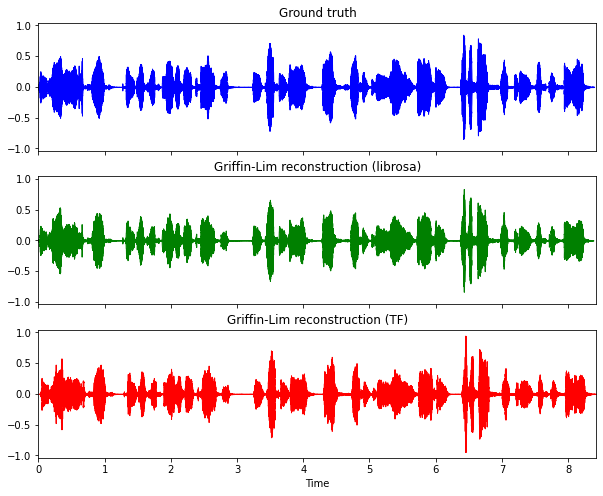

In [8]:
_, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8), sharey=True, sharex=True)
librosa.display.waveplot(gt_wav, sr=config["sampling_rate"], color="b", ax=ax1)
ax1.set_title("Ground truth")
ax1.set_xlabel("")
librosa.display.waveplot(inv_wav_lb, sr=config["sampling_rate"], color="g", ax=ax2)
ax2.set_title("Griffin-Lim reconstruction (librosa)")
ax2.set_xlabel("")
librosa.display.waveplot(
    inv_wav_tf[0].numpy(), sr=config["sampling_rate"], color="r", ax=ax3
)
ax3.set_title("Griffin-Lim reconstruction (TF)");

In [9]:
def gen():
    file_list = glob.glob("../dump/train/norm-feats/*-norm-feats.npy")
    for file in file_list:
        yield np.load(file)


mel_ds = tf.data.Dataset.from_generator(
    gen, (tf.float32), tf.TensorShape([None, config["num_mels"]])
).padded_batch(10)

for mel_batch in mel_ds.take(5):
    start_batch = time.perf_counter()
    inv_wav_tf_batch = griffin_lim_tf(mel_batch)
    print(
        f"Iteration time: {time.perf_counter() - start_batch:.4f}s, output shape: {inv_wav_tf_batch.shape}"
    )

Iteration time: 46.1579s, output shape: (10, 206336)
Iteration time: 49.9080s, output shape: (10, 218624)
Iteration time: 49.4804s, output shape: (10, 219648)
Iteration time: 51.8307s, output shape: (10, 221952)
Iteration time: 48.4572s, output shape: (10, 210944)


Saving outputs with both implementations.

In [10]:
# Single file
griffin_lim_lb(mel_spec, stats_path, config, output_dir=tempfile.gettempdir(), wav_name="lb")
griffin_lim_tf.save_wav(inv_wav_tf, output_dir=tempfile.gettempdir(), wav_name="tf")

# Batch files
griffin_lim_tf.save_wav(inv_wav_tf_batch, tempfile.gettempdir(), [x for x in range(10)])

%ls {tempfile.gettempdir()} | grep '.wav'

0.wav
1.wav
2.wav
3.wav
4.wav
5.wav
6.wav
7.wav
8.wav
9.wav
lb.wav
tf.wav
